In [1]:
from astropy.table import Table
import numpy as np
lens_samples = Table.read('lens_samples.fits')
mask_stack = lens_samples['if_obs_stack'].data
mask_single = lens_samples['if_obs_single'].data
stack_samples = lens_samples[mask_stack]
single_samples = lens_samples[mask_single]
stack_samples.sort('SNR_stack')
single_samples.sort('SNR_stack')
print(np.count_nonzero(mask_stack), np.count_nonzero(mask_single))

161658 76481


In [2]:
stack_samples[0:3]

thetaE_s0,mass_s0,z_s0,re_s0,q_s0,pa_s0,x_s0,y_s0,mag_g_s0,mag_r_s0,mag_i_s0,mag_z_s0,vdisp_l,re_l,q_l,z_l,mag_g_l,mag_r_l,mag_i_l,mag_z_l,SNR_g,SNR_r,SNR_i,SNR_z,SNR_stack,best_band,mu,if_ring,if_obs_stack,if_obs_single,noise_seed
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,bool,bool,bool,int64
0.2515839339238274,42588092643.569145,1.954,0.12071596852606585,0.26938157874585034,11.061087913095125,0.14346745625717985,0.05273782564719767,25.7805,26.2168,25.8127,25.5663,168.39257956842667,0.37870776946943113,0.7250000858634702,1.0998569447400999,28.839741491795806,26.078749169326873,24.696209225450783,23.29584175334981,14.9222188047246,8.052618540639713,9.432092061743722,7.610120987969949,20.000063329549405,g,3.969243529790156,True,True,False,1459
0.65809837615499,112132690882.41939,2.4352,0.21492642425191413,0.48179003496854256,144.82478215475302,0.11683699122247626,-0.13407458544241252,25.6169,25.3852,25.6149,25.2763,189.49939330649872,0.3259695212363595,0.5280965997000937,0.5647732546878779,23.865671954781675,22.023680653003634,20.757378609202643,20.20085104067254,12.887871418415607,12.283184514006514,7.964865211298842,7.070928539944982,20.000137257143404,g,5.931378028673581,True,True,False,781
0.9632576424948887,321010828515.9149,1.0121,0.07803567144969906,0.9174455708027653,23.346871797448937,-0.24977598830169842,0.5762380059067224,27.8756,26.4087,25.407,24.5888,274.7541374009836,0.9294248900103025,0.5723507560367336,0.49079417311345364,21.354909886931388,19.48661048185661,18.450793625434834,17.93077181308079,2.5212789128752697,6.865723601459501,12.736286942002346,16.48292697299501,20.000324223838547,z,3.008005138174397,False,True,False,479


In [3]:
lens_id = 50 
stack_samples[lens_id]['SNR_stack']

20.003532360883288

In [4]:
24+2.5*np.log10(3.1)

25.228404234585682

snr of arc is 16.62154133062373


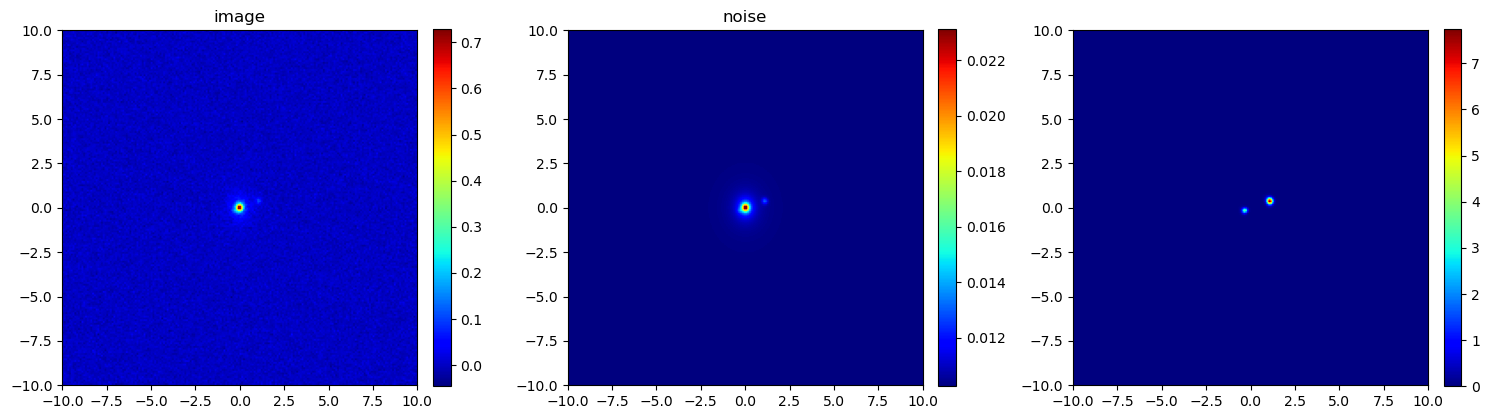

7.738771582435769


In [5]:
from SimCsstLens.SimLensImage import MassLightModel as MLM
from SimCsstLens.SimLensImage import Simulator
from SimCsstLens.SimLensImage import Util as SSU
from matplotlib import pyplot as plt

this_tab_row = stack_samples[lens_id]

dpix = 0.1
zero_mag = 25.23
psf_kernel = SSU.gauss_psf(
    npix=None, 
    dpix=dpix, 
    sigma=None, 
    fwhm=0.18, 
    ree80=None, 
    nsub=4
)
skyback = SSU.sky_cps_from_mag(22.35, zero_mag, dpix) #sky background in unit of counts/s/pix

this_lens_mass = [
    MLM.SieMass(
        xc=0.0, 
        yc=0.0, 
        q=this_tab_row['q_l'], 
        PA=90.0, #manually requirment, consistent to the lenspop code, just used for code debugging 
        thetaE=this_tab_row['thetaE_s0'],        
    ),
]

lens_vis_mag = (this_tab_row['mag_r_l'] + this_tab_row['mag_i_l'] + this_tab_row['mag_z_l'])/3.0
this_lens_light = [
    MLM.SersicLight(        
        xc=0.0, 
        yc=0.0, 
        q=this_tab_row['q_l'], 
        PA=90.0, #manually requirment, consistent to the lenspop code, just used for code debugging
        Re=this_tab_row['re_l'], 
        Ie=None, 
        n=4.0,
        m=lens_vis_mag,
        mag_zero=zero_mag, #zero mag for e-/s
    ),
]

src_vis_mag = (this_tab_row['mag_r_s0'] + this_tab_row['mag_i_s0'] + this_tab_row['mag_z_s0'])/3.0
this_source_light = [
    MLM.SersicLight(
        xc=this_tab_row['x_s0'], 
        yc=this_tab_row['y_s0'], 
        q=this_tab_row['q_s0'], 
        PA=this_tab_row['pa_s0'], 
        Re=this_tab_row['re_s0'], 
        Ie=None, 
        n=1.0,
        m=src_vis_mag,
        mag_zero=zero_mag,    
    )
]
    
this_sim_obj = Simulator.SingleBandSimulator(
    lens_light_models=this_lens_light,
    lens_mass_models=this_lens_mass,
    source_light_models=this_source_light,
)

this_sim_obj.generate_ideal_image(npix=200, dpix=dpix, nsub=2)


this_sim_obj.overlay_instrument_effect(
    psf=psf_kernel, #a 2d psf kernel image
    skylevel=skyback, #unit: counts/s/pix
    dark_current=0, #unit: counts/s/pix
    readout_noise=4.5, #unit: counts/pix
    n_exposures=3, 
    exposure_time=565*3, #effective expsoure time
)

lensed_arc_cps = this_sim_obj.blurred_image_cps - this_sim_obj.blurred_lens_image_cps
this_snr = SSU.SN_from_lensed_image(
    lensed_arc_cps, 
    this_sim_obj.noise_map_cps,
)
print('snr of arc is', this_snr)

plt.figure(figsize=(15,5))
plt.subplot(131)

plt.imshow(
    this_sim_obj.image_map_cps, 
    origin='lower', 
    cmap='jet', 
    extent=this_sim_obj.extent,
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('image')

plt.subplot(132)
plt.imshow(
    this_sim_obj.noise_map_cps, 
    origin='lower', 
    cmap='jet', 
    extent=this_sim_obj.extent,
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('noise')

plt.subplot(133)
plt.imshow(
    lensed_arc_cps/this_sim_obj.noise_map_cps,
    origin='lower', 
    cmap='jet', 
    extent=this_sim_obj.extent,
)
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
print((lensed_arc_cps/this_sim_obj.noise_map_cps).max())

import copy 
this_sim_obj_euclid = copy.deepcopy(this_sim_obj) 

## CSST

In [7]:
from SimCsstLens.SimLensImage.MockSurvey import MockSurvey
from SimCsstLens.SimLensImage import Util as SSU

class NewMockSurvey(MockSurvey):
    def load_ideal_lens_from_table(self, this_table):
        self.src_z = this_table['z_s0'].data.reshape(1, -1)
        self.src_xs = this_table['x_s0'].data.reshape(1, -1)
        self.src_ys = this_table['y_s0'].data.reshape(1, -1)
        self.src_Re = this_table['re_s0'].data.reshape(1, -1)
        self.src_q = this_table['q_s0'].data.reshape(1, -1)
        self.src_pa = this_table['pa_s0'].data.reshape(1, -1)
        self.src_thetaE = this_table['thetaE_s0'].data.reshape(1, -1)
        
        self.dfl_Re = this_table['re_l'].data
        self.dfl_z = this_table['z_l'].data
        self.dfl_q = this_table['q_l'].data
        self.dfl_vdisp = this_table['vdisp_l'].data
        for band in self.bands[0:-1]:
            self.__dict__[f'src_app_mag_{band}'] = this_table[f'mag_{band}_s0'].data.reshape(1, -1)
            self.__dict__[f'dfl_app_mag_{band}'] =  this_table[f'mag_{band}_l'].data
        self.n_ideal_lenses = len(self.dfl_z)

        
from SimCsstLens.SimLensImage.MockSurvey import MockSurvey
survey = NewMockSurvey(config_path="./", config_file='csst_setting.yaml')
survey.load_ideal_lens_from_table(stack_samples)

this_sim_obj = survey.sim_obj_from(lens_id)
survey.lensing_image_from(this_sim_obj)
this_sn, this_mu = survey.sn_and_mu_from(this_sim_obj)
print(this_sn, '-----')

[[14.21144912  9.84396877  9.35746999  6.48678542 20.00353236]] -----


In [8]:
def vis_sim_obj(band, this_sim_obj):
    src_id = 0
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    try:
        image_cps = this_sim_obj[src_id][band]['image_map_cps']
    except:
        image_cps = this_sim_obj[src_id][band].image_map_cps
    plt.imshow(
        image_cps, 
        origin='lower', 
        cmap='jet', 
        extent=this_sim_obj[src_id]["stack"]['extent'],
    )
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('image')
    try:
        noise_cps = this_sim_obj[src_id][band]['noise_map_cps']
    except:
        noise_cps = this_sim_obj[src_id][band].noise_map_cps
    plt.subplot(132)
    plt.imshow(
        noise_cps, 
        origin='lower', 
        cmap='jet', 
        extent=this_sim_obj[src_id]["stack"]['extent'],
    )
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('noise')
    try:
        arc_cps = this_sim_obj[src_id][band]['lensed_arc_cps']
    except:
        arc_cps = this_sim_obj[src_id][band].blurred_image_cps - this_sim_obj[src_id][band].blurred_lens_image_cps
    plt.subplot(133)
    plt.imshow(
        arc_cps/noise_cps,
        origin='lower', 
        cmap='jet', 
        extent=this_sim_obj[src_id]["stack"]['extent'],
    )
    
    this_sn = SSU.SN_from_lensed_image(arc_cps, noise_cps)
    print(this_sn, np.max(arc_cps/noise_cps))
    
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

20.003532360883288 9.835548763353447


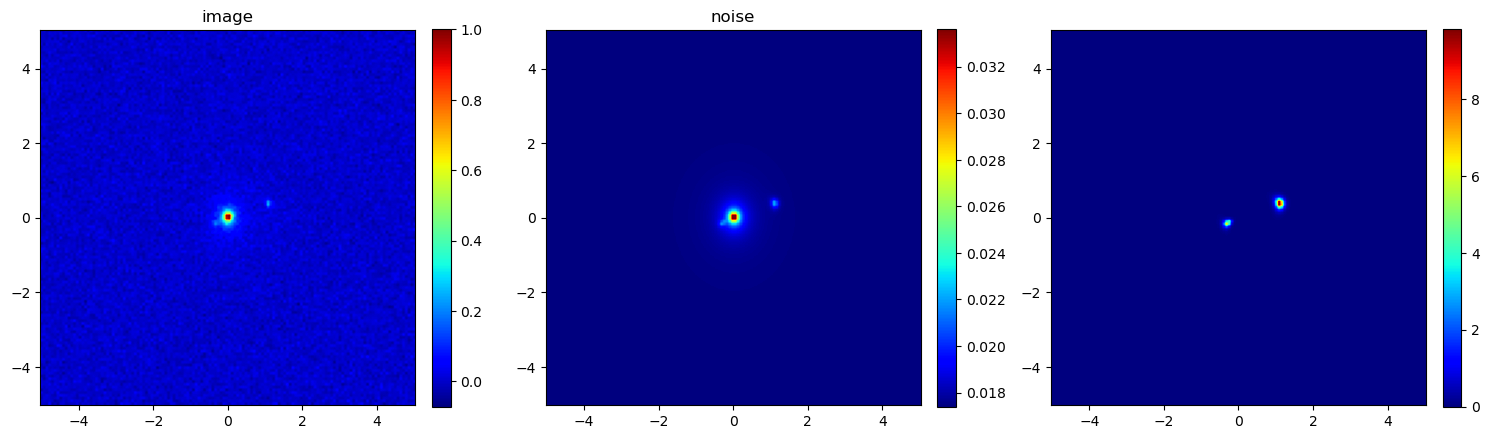

In [9]:
vis_sim_obj('stack', this_sim_obj)

14.211449118812807 6.877273852534855


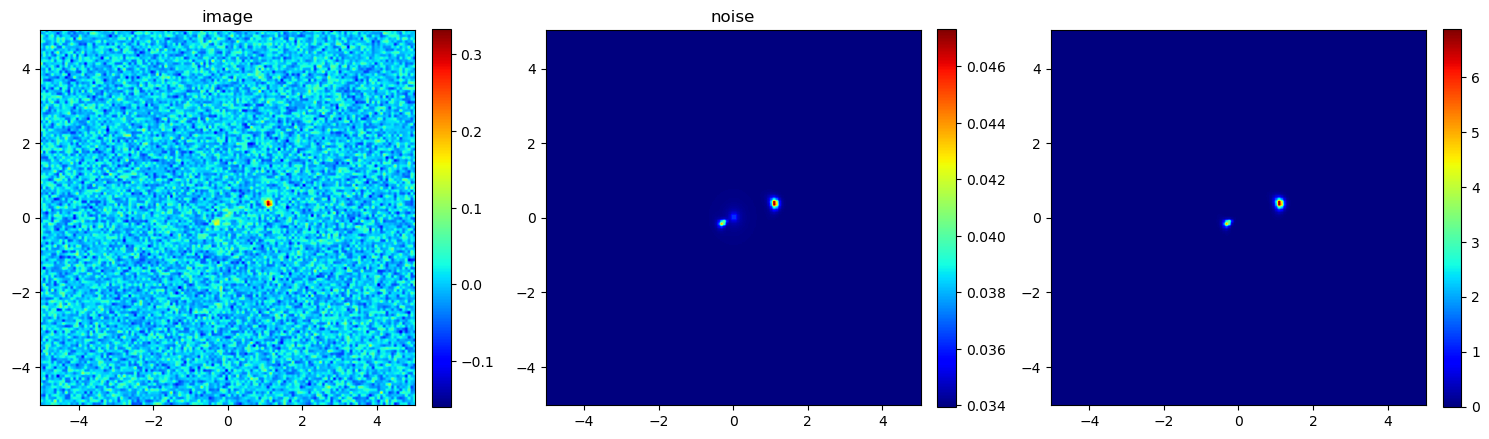

In [10]:
vis_sim_obj('g', this_sim_obj)

9.8439687657977 4.828153691398366


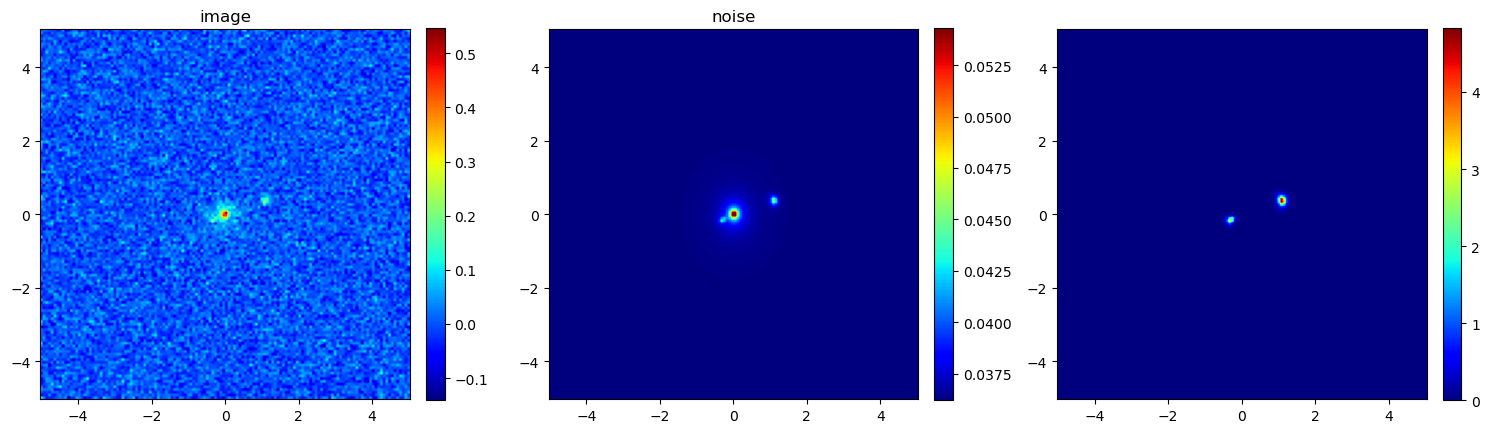

In [11]:
vis_sim_obj('r', this_sim_obj)

9.357469991570142 4.518303542555874


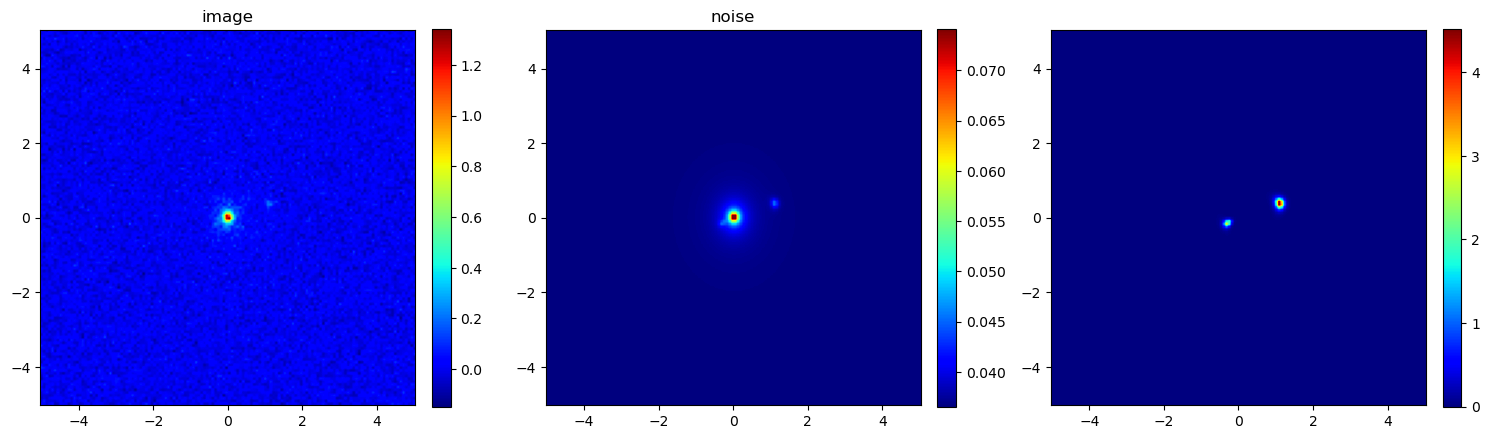

In [12]:
vis_sim_obj('i', this_sim_obj)

6.48678542373446 3.156608159911345


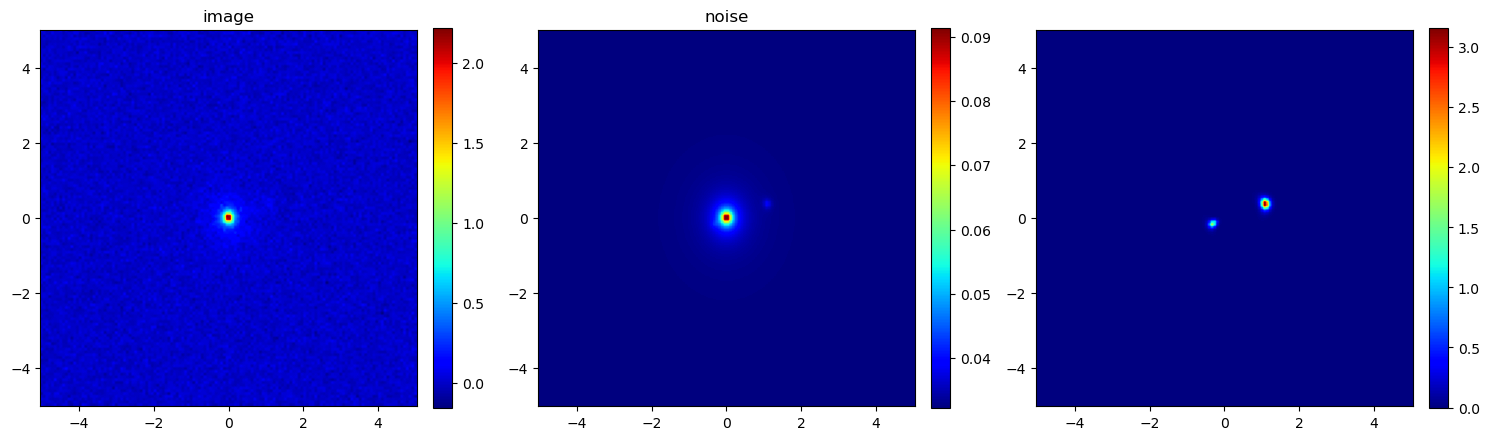

In [13]:
vis_sim_obj('z', this_sim_obj)

## plot for paper

In [14]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import make_lupton_rgb
from matplotlib.colors import LogNorm
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use(['science','no-latex', 'nature'])
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# Set the background color and grid style
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.alpha'] = 0.5

columnwidth = 3.33
row_length = columnwidth*3
aspect_ratio = 2.0/3.0
fig = plt.figure(figsize=(row_length+0.2, row_length*aspect_ratio+0.1))
# fig = plt.figure(figsize=(12,8))


plt.subplot(231)
this_ax = plt.gca()
band = 'g'
arc_cps = this_sim_obj[0][band].blurred_image_cps - this_sim_obj[0][band].blurred_lens_image_cps
noise_cps = this_sim_obj[0][band].noise_map_cps
im = this_ax.imshow(arc_cps/noise_cps, cmap='Greys', origin='lower', extent=this_sim_obj[0]["stack"]['extent'])
this_ax.set_aspect('equal')
divider = make_axes_locatable(this_ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im, cax=cax)
this_ax.text(0.05, 0.85, f"CSST-{band}", transform = this_ax.transAxes)
this_sn = SSU.SN_from_lensed_image(arc_cps, noise_cps)
this_ax.text(0.05, 0.05, f"Arc-SNR: {this_sn:.2f}", transform = this_ax.transAxes)
this_ax.set_xlim(-3,3)
this_ax.set_ylim(-3,3)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

plt.subplot(232)
this_ax = plt.gca()
band = 'r'
arc_cps = this_sim_obj[0][band].blurred_image_cps - this_sim_obj[0][band].blurred_lens_image_cps
noise_cps = this_sim_obj[0][band].noise_map_cps
im = this_ax.imshow(arc_cps/noise_cps, cmap='Greys', origin='lower', extent=this_sim_obj[0]["stack"]['extent'])
this_ax.set_aspect('equal')
divider = make_axes_locatable(this_ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im, cax=cax)
this_ax.text(0.05, 0.85, f"CSST-{band}", transform = this_ax.transAxes)
this_sn = SSU.SN_from_lensed_image(arc_cps, noise_cps)
this_ax.text(0.05, 0.05, f"Arc-SNR: {this_sn:.2f}", transform = this_ax.transAxes)
this_ax.set_aspect('equal')
this_ax.set_xlim(-3,3)
this_ax.set_ylim(-3,3)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

plt.subplot(233)
this_ax = plt.gca()
band = 'i'
arc_cps = this_sim_obj[0][band].blurred_image_cps - this_sim_obj[0][band].blurred_lens_image_cps
noise_cps = this_sim_obj[0][band].noise_map_cps
im = this_ax.imshow(arc_cps/noise_cps, cmap='Greys', origin='lower', extent=this_sim_obj[0]["stack"]['extent'])
this_ax.set_aspect('equal')
divider = make_axes_locatable(this_ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im, cax=cax)
this_ax.text(0.05, 0.85, f"CSST-{band}", transform = this_ax.transAxes)
this_sn = SSU.SN_from_lensed_image(arc_cps, noise_cps)
this_ax.text(0.05, 0.05, f"Arc-SNR: {this_sn:.2f}", transform = this_ax.transAxes)
this_ax.set_aspect('equal')
this_ax.set_xlim(-3,3)
this_ax.set_ylim(-3,3)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

plt.subplot(234)
this_ax = plt.gca()
band = 'z'
arc_cps = this_sim_obj[0][band].blurred_image_cps - this_sim_obj[0][band].blurred_lens_image_cps
noise_cps = this_sim_obj[0][band].noise_map_cps
im = this_ax.imshow(arc_cps/noise_cps, cmap='Greys', origin='lower', extent=this_sim_obj[0]["stack"]['extent'])
this_ax.set_aspect('equal')
divider = make_axes_locatable(this_ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im, cax=cax)
this_ax.text(0.05, 0.85, f"CSST-{band}", transform = this_ax.transAxes)
this_sn = SSU.SN_from_lensed_image(arc_cps, noise_cps)
this_ax.text(0.05, 0.05, f"Arc-SNR: {this_sn:.2f}", transform = this_ax.transAxes)
this_ax.set_aspect('equal')
this_ax.set_xlim(-3,3)
this_ax.set_ylim(-3,3)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

plt.subplot(235)
this_ax = plt.gca()
arc_cps = this_sim_obj[0]['stack']['lensed_arc_cps']
noise_cps = this_sim_obj[0]['stack']['noise_map_cps']
im = this_ax.imshow(arc_cps/noise_cps, cmap='Greys', origin='lower', extent=this_sim_obj[0]["stack"]['extent'])
this_ax.set_aspect('equal')
divider = make_axes_locatable(this_ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im, cax=cax)
this_ax.text(0.05, 0.85, "CSST-stack", transform = this_ax.transAxes)
this_sn = SSU.SN_from_lensed_image(arc_cps, noise_cps)
this_ax.text(0.05, 0.05, f"Arc-SNR: {this_sn:.2f}", transform = this_ax.transAxes)
this_ax.set_aspect('equal')
this_ax.set_xlim(-3,3)
this_ax.set_ylim(-3,3)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

plt.subplot(236)
this_ax = plt.gca()
lensed_arc_cps = this_sim_obj_euclid.blurred_image_cps - this_sim_obj_euclid.blurred_lens_image_cps
im = this_ax.imshow(lensed_arc_cps/this_sim_obj_euclid.noise_map_cps, cmap='Greys', origin='lower', extent=this_sim_obj_euclid.extent)
this_ax.set_aspect('equal')
divider = make_axes_locatable(this_ax)
cax = divider.append_axes("right", size="5%", pad=0.05) 
plt.colorbar(im, cax=cax)
this_ax.text(0.05, 0.85, "Euclid-VIS", transform = this_ax.transAxes)
this_sn = SSU.SN_from_lensed_image(lensed_arc_cps, this_sim_obj_euclid.noise_map_cps)
this_ax.text(0.05, 0.05, f"Arc-SNR: {this_sn:.2f}", transform = this_ax.transAxes)
this_ax.set_aspect('equal')
this_ax.set_xlim(-3,3)
this_ax.set_ylim(-3,3)
this_ax.set_xticklabels([])
this_ax.set_yticklabels([])
this_ax.set_xticks([])
this_ax.set_yticks([])

plt.tight_layout()
fig.savefig('figures/csst_euclid_imaging_depth.pdf', bbox_inches='tight')
plt.close(fig)